Obtener el fichero usando la librería requests

In [4]:
import requests as rq
import bz2

request = rq.get("https://gist.github.com/juanriaza/9b6f7ab3fc1cbda81100fa5d32512fd8/raw/a61db2d8d81789d5c7040eacee7b225bc2b2aa7f/data.csv.bz2")
target_path = 'file.csv.bz2'

if request.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(request.content)
        
f_in = open("file.csv.bz2", "rb")
f_out = open("file.csv", "wb")
f_out.write(bz2.decompress(f_in.read()))
f_out.close()
f_in.close()

#dbfile = bz2.BZ2File(bz2file)
#dbconn = sqlite3.connect(dbfile)

Usando línea de comandos importar los datos de dicho fichero en una base de datos que resida en un fichero SQLite. 

In [5]:
import sqlite3 
import pandas as pd

conn = sqlite3.connect(r'database.db')
c=conn.cursor()

df = pd.read_csv('file.csv', sep = '|')
df.to_sql('Datos', conn, if_exists='append', index=False)

df = pd.read_sql_query("select * from Datos;", conn)

conn.close()


 Usando la librería sqlite3 deberás responder a las siguientes preguntas mediante queries SQL:

In [7]:
conn = sqlite3.connect(r'database.db')
c=conn.cursor()



#Número de inmuebles en alquiler que tiene cada cliente profesional por código postal
df11 = pd.read_sql_query("select customer_id, zipcode, count(*) from Datos where is_professional = 1 and transaction_type = 'rent'  group by customer_id, zipcode;", conn)

#Obtén los siguientes códigos postales de la ciudad de Barcelona:
#Código postal del precio por metro cuadrado más barato
df12 = pd.read_sql_query("select zipcode, price/area from Datos where zipcode like '08%' and transaction_type = 'sale' and price/area <> 'None' and price/area <> 0 order by 2 limit 1;", conn)


#Código postal del precio por metro cuadrado más caro
df13 = pd.read_sql_query("select zipcode, price/area from Datos where zipcode like '08%' and transaction_type = 'sale' order by 2 desc limit 1;", conn)


#Cliente profesional que tiene la cartera de inmuebles más envejecida
df14 = pd.read_sql_query("select customer_id, CAST(AVG(CAST( date_added  AS INT)) AS DATETIME) from Datos where is_professional = 1 group by customer_id order by 2 asc limit 1;", conn)

#En qué ciudad se encuentra el terreno urbanizable más caro?
df15 = pd.read_sql_query("select city, price from Datos where subtypology = 'Terreno Urbanizable' order by 2 desc limit 1;", conn)


conn.close()


Realiza los mismos ejercicios del apartado 4 utilizando la librería pandas

In [8]:
import numpy as np

#Número de inmuebles en alquiler que tiene cada cliente profesional por código postal
df21 = df.loc[df['is_professional'] == 1].groupby(['customer_id', 'zipcode']).count()[['typology']]

#Obtén los siguientes códigos postales de la ciudad de Barcelona:
#Código postal del precio por metro cuadrado más barato
df['preciopormetrocuadrado'] = df['price'] / df['area']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["preciopormetrocuadrado"], how="all") 

df22 = df.loc[df['transaction_type'] == 'sale'].loc[df['city'] == 'Barcelona Capital']\
        .loc[df['price'] > 0] \
        .sort_values(by=['price'], ascending=True)


#Código postal del precio por metro cuadrado más caro
df23 = df.loc[df['transaction_type'] == 'sale'].loc[df['city'] == 'Barcelona Capital']\
        .loc[df['price'] > 0] \
        .sort_values(by=['price'], ascending=False)


#Cliente profesional que tiene la cartera de inmuebles más envejecida
df.date_added = pd.to_datetime(df.date_added).values.astype(np.int64)
df24 = df.loc[df['is_professional'] == 1].groupby(['customer_id']).mean()[['date_added']].\
        sort_values(by=['date_added'], ascending=True)


#En qué ciudad se encuentra el terreno urbanizable más caro?
df25 = df.loc[df['subtypology'] == 'Terreno Urbanizable'].sort_values(by=['price'], ascending=False)


Un inversor quiere saber por código postal qué propiedades son interesantes. Añade al dataframe de pandas las siguientes columnas:

over_valued (0/1)

normal(0/1)

under_valued (0/1) 


Qué código postal tiene el mayor número de "chollos"?

In [9]:
preciosmediosdf=df.loc[df['transaction_type'] == 'sale'].groupby(['zipcode']).mean()[['preciopormetrocuadrado']]
preciosmediosdf['PrecioMedioMetroCuadrado']=preciosmediosdf['preciopormetrocuadrado']
preciosmediosdf = preciosmediosdf.drop(['preciopormetrocuadrado'], axis=1)

JOIN = df.merge(preciosmediosdf, on='zipcode', how='left')

JOIN['over_valued'] = np.where(JOIN['preciopormetrocuadrado'] > 1.2 *JOIN['PrecioMedioMetroCuadrado'] , 1, 0)
JOIN['normal'] = np.where((JOIN['preciopormetrocuadrado'] >= 0.8 *JOIN['PrecioMedioMetroCuadrado']) & (JOIN['preciopormetrocuadrado'] <= 1.2 *JOIN['PrecioMedioMetroCuadrado']), 1, 0)
JOIN['under_valued'] = np.where(JOIN['preciopormetrocuadrado'] < 0.8 *JOIN['PrecioMedioMetroCuadrado'], 1, 0)


chollos = JOIN.groupby(['zipcode']).sum()[['under_valued']].sort_values(by=['under_valued'], ascending=False)


 Guarda el nuevo dataframe del anterior apartado en un fichero json comprimido con gzip

In [40]:
chollos.to_json(r'chollos.json')
#JOIN.to_json(r'JOIN.json')

Como ejercicio extra realizaremos una visualización de un histograma de los precios de las viviendas en ventas para comprar los previos de Barcelona capital con los dos núcleos urbanos contiguos más importantes. 

 

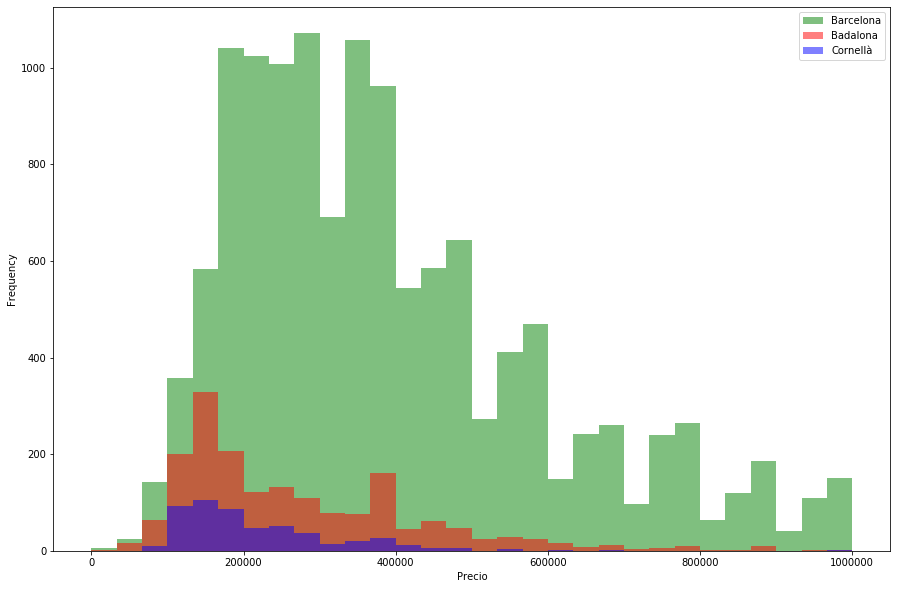

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
BCN = JOIN.loc[JOIN['transaction_type'] == 'sale'].\
        loc[JOIN['city'] == 'Barcelona Capital'].loc[JOIN['typology'] == 'Vivienda']["price"].\
        plot(kind='hist', bins=30, range=(1, 1000000), color='g', alpha = 0.5)
BDN = JOIN.loc[JOIN['transaction_type'] == 'sale'].\
        loc[JOIN['city'] == 'Badalona'].loc[JOIN['typology'] == 'Vivienda']["price"].\
        plot(kind='hist', bins=30, range=(1, 1000000), color='r', alpha = 0.5)
COR = JOIN.loc[JOIN['transaction_type'] == 'sale'].\
        loc[JOIN['city'] == 'Cornellà de Llobregat'].loc[JOIN['typology'] == 'Vivienda']["price"].\
        plot(kind='hist', bins=30, range=(1, 1000000), color='b', alpha = 0.5)

plt.xlabel("Precio", fontdict=None, labelpad=None)
BCN.legend(labels = ["Barcelona", "Badalona", "Cornellà"])